## Donovan Mosheh Ramirez Trejo
#### NOTA: 

El siguiente código fue hecho en equipo pero para mantener la privacidad de los demas integrantes se quitaron sus datos

- Substituir la función de costo: J(**w**) = - $\sum_{i=1}^{m} y^{(i)} \log{\phi{(z^{i})}} + (1 - y^{(i)})\log{[1-\phi{(z^{i})}]}$
-  Substituir la función de activacion lineal (la función identidad) por la función de activacion sigmoide: $\phi{(z)} = \frac{1}{(1 + e^{(-z)})}$
- Modificar la funcion de umbral (la funcion escalon) para que devuelva las etiquetas 0 y 1 en lugar de las etiquetas −1 y +1

*Python Machine Learning 2nd Edition* by [Sebastian Raschka](https://sebastianraschka.com), Packt Publishing Ltd. 2017

Code Repository: https://github.com/rasbt/python-machine-learning-book-2nd-edition

Code License: [MIT License](https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/LICENSE.txt)

### Reading-in the Iris data

In [1]:
from sklearn import datasets
import numpy as np
import time

iris = datasets.load_iris()
X = iris.data[0:100, [2, 3]]
y = iris.target[0:100]

print('Class labels:', np.unique(y))

Class labels: [0 1]


Splitting data into 70% training and 30% test data:

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [3]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [50 50]
Labels counts in y_train: [35 35]
Labels counts in y_test: [15 15]


<hr>

### Plotting the Iris data

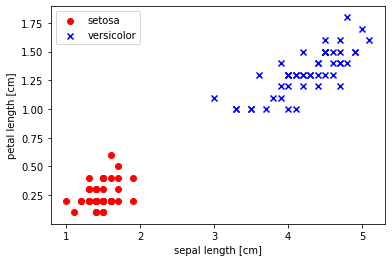

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# plot data
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='x', label='versicolor')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.show()

### A function for plotting decision regions

In [5]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

## Implementing a Logistic Regression classifier

En esta parte del codigo hacemos la substitución de la función de activación lineal por la acivación sigmoide, pero para esto, tenemos que saber que es tal función.

Se trata de una función continua no lineal con bastante plausibilidad fisiológica, es la función de activación mas antigua y popular en el área de la inteligencia artificial y las redes neuronales.
Esta función actúa como una especie de función “aplastadora”, comprimiendo nuestra salida a un rango de 0 a 1.

A esta función, le vamos a dar uso en la función de coste, que es:

J(**w**) = - $\sum_{i=1}^{m} y^{(i)} \log{\phi{(z^{i})}} + (1 - y^{(i)})\log{[1-\phi{(z^{i})}]}$

In [6]:
from IPython.display import clear_output

class LogisticRegressionGD(object):
    """Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Sum-of-squares cost function value in each epoch.

    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []
        
        
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = - ((y @ np.log(output)) + ((1 - y) @ np.log(1 - output)))
            self.cost_.append(cost)
            
            plot_decision_regions(X=X_train_01_subset, 
            y=y_train_01_subset,
            classifier=lrgd)

            plt.xlabel('petal length [standardized]')
            plt.ylabel('petal width [standardized]')
            plt.legend(loc='upper left')


            clear_output(wait=True)
            print("------ NUMEROS DE INTENTOS ------")
            print("Intento",i)
            print("Coste:",cost)
            print("Error:",errors.sum())
            plt.tight_layout()
            plt.show()
            time.sleep(0.8)
            
            if abs(errors.sum()) <= 1.5 and i>5:
                break
            
           
        return self
        
    def net_input(self, X):
        """Calculate net input"""
        return X @ self.w_[1:] + self.w_[0]
        
        
    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

## Time to plot

Para que podamos ver mejor el comportamiento de los nuevos ajustes, hemos decido hacer el **plot** cada que hay un cambio y gracias a esto se puede ver como cada vez se ajusta mejor a los datos. Dicho **plot** no se detendrá hasta que encuentre un error menor a 1.5 o se acaben las iteraciones

------ NUMEROS DE INTENTOS ------
Intento 8
Coste: 4.097991124795176
Error: -1.1177925340289376


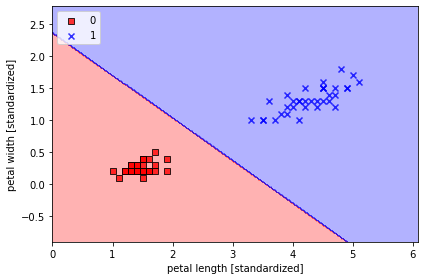

In [7]:
X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]


lrgd = LogisticRegressionGD(eta=0.05, n_iter=100, random_state=1)
lrgd.fit(X_train_01_subset,y_train_01_subset)

## Referencias

http://rna.50webs.com/tutorial/RNA_intro.html

https://ml4a.github.io/ml4a/es/neural_networks/